**homolog visualization for certain sigle gene as input**

- need to have 'distance value' from input gene and matched gene with blast output. 
- the distance values should be comparable with other input gene. 


using 

```
modified similarity measure(ms) = (similarity*2*alignment_length) / (query_length + subject_length)
```

the position of query gene and subject gene would be determined as follow

```
md(max.distance) = 100
l                = (1-ms) * md
theta            = (1-ms) * 360
x                = l * cos(theta)
y                = l * sin(theta)
```

In [130]:
from __future__ import print_function
import pandas as pd
import numpy as np
import sys
sys.path.append('../../pipelines/')
import kang
from IPython.display import SVG, display

In [94]:
file_bo = '../../DroughtNet/blast/Athaliana_167.fa.pep.fa.bp.ev1e5.out7.rmsharp.txt'
df_bo   = pd.read_csv(file_bo,sep='\t',header=None)
file_pep = '../../DroughtNet/blast/Athaliana_167.fa.pep.fa'
dic_pep = kang.Fasta2dic(file_pep)

In [4]:
file_gff = '../../DroughtNet/PhytozomeV10_download/PhytozomeV10/Athaliana/annotation/Athaliana_167_TAIR10.gene.gff3'

In [195]:
df_gff   = pd.read_csv(file_gff,sep='\t',skiprows=2,header=None)

In [12]:
df_gff['genename'] = df_gff[8].apply(lambda x : x.split(';')[0].replace('ID=','').split('.')[0])
df_gff['transcriptname'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:2]))
# grep longest transcript names
mask        = (df_gff[2] == 'mRNA')
df_gff_mRNA = df_gff[mask]
df_gff_mRNA['longest'] = df_gff_mRNA[8].apply(lambda x : x.split(';')[3].replace('longest=',''))
df_gff_mRNA_index =  df_gff_mRNA.set_index('transcriptname')

def get_longest(x):
    try:
        return df_gff_mRNA_index.loc[x]['longest']
    except KeyError:
        return None
df_gff['longest'] = df_gff['transcriptname'].apply(get_longest)



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
df_gff_index = df_gff.set_index(['transcriptname',2])

In [84]:
df_gff_mRNA_index = df_gff_mRNA.set_index('transcriptname')

In [86]:
mask      = (df_bo[10] < 1*np.exp(-5)) & (df_bo[2] > 40 )
df_bo_cut = df_bo[mask]
print len(df_bo),len(df_bo_cut)

1964030 315218


In [106]:
%time df_bo_cut['ql'] = df_bo_cut[0].apply(lambda x : len(dic_pep[x]))
df_bo_cut['sl'] = df_bo_cut[1].apply(lambda x : len(dic_pep[x]))

CPU times: user 111 ms, sys: 4 ms, total: 115 ms
Wall time: 115 ms


In [107]:
df_bo_cut['msim'] = ((df_bo_cut[2]/100)*2*df_bo_cut[3])/(df_bo_cut['ql'] + df_bo_cut['sl'])

In [187]:
md               = 100
xaxis            = 150 # xaxis location in svg space 
yaxis            = 150
query_rad        = 10

def get_xy(ms):

    l                = (1-ms)**2 * md + query_rad + 5 # square amplify signal
    theta            = (1-ms) * np.pi*2
    x                = l * np.cos(theta)
    y                = l * np.sin(theta)
    #print(ms,l,theta)
    return l,theta,xaxis+x,yaxis-y
get_xy_vec = np.vectorize(get_xy)

In [189]:
l,theta,x, y = get_xy_vec(df_bo_cut['msim'])
df_bo_cut['x'] = x
df_bo_cut['y'] = y
df_bo_cut['l'] = l
df_bo_cut['theta'] = theta
df_bo_cut_index = df_bo_cut.set_index(0)

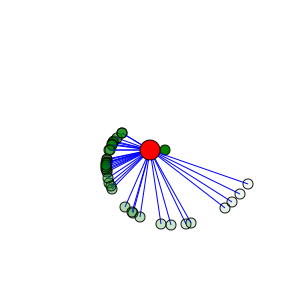

In [194]:
canvas_height = 300
canvas_width  = 300
genename      = 'AT3G44790.1'
Outfile       = open(genename+'.boviz.svg','w')
circle = '<circle cx="%d" cy="%d" r="%d" \
          style="fill:%s;stroke:black;stroke-width:1;fill-opacity:%f;stroke-opacity:0.9" />'
line   = '<line x1="%d" y1="%d" x2="%d" y2="%d" stroke="%s" stroke-width="1" />' 
print('<svg height="%d" width="%d">'%(canvas_height,canvas_width),file=Outfile)

if str(type(df_bo_cut_index.loc[genename])) == "<class 'pandas.core.frame.DataFrame'>":
    for x,y,msim in df_bo_cut_index.loc[genename][['x','y','msim']].values:
        print(line%(xaxis,yaxis,x,y,'blue'),file=Outfile)
        print(circle%(x,y,5,'green',msim),file=Outfile)
        #print(x,y)
print(circle%(xaxis,yaxis,query_rad,'red',1),file=Outfile)
print('</svg>',file=Outfile)
Outfile.close()     
display(SVG('./%s.boviz.svg'%genename))